In [203]:

# pip install git+git://github.com/xapharius/cppmagic. 
%load_ext cppmagic

The cppmagic extension is already loaded. To reload it, use:
  %reload_ext cppmagic


In [23]:
import numpy as np
np.random.seed(0)  # seed for reproducibility

# STATS 607: Advanced statistical programming
##### Instructor
JT <jonth@umich><br/>
##### Office hours
Tuesday/Thursday 4-5pm, or by appointment
##### Grading
- Three problem sets, each worth 25%, can work in pairs, due approximately every two weeks.
- Individual final project, also worth 25%.
##### Important links:
- https://umich.instructure.com/courses/717115 (Canvas site)
- Slack workspace (in progress)

### Goals of this class
- Learn how to effectively use things like array programming, autodiff, GPUs, etc. to write better/faster/more stable research code.
- "Double dipping" is encouraged: final project should ideally be something related to your research. 
- If there are particular topics or skills that would be useful for your research, **please let me know**.
- **Ideal outcome**: this class helps you move your research forward.


In [1]:
from IPython.display import IFrame
sched = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRw5hr7idg1jHvsOd1YT2tFzzM07P1Lrcwx-fB54_ojeXZr_-Wz0Dk2j-Cpa7n0oXyjRyZlYZw5ezXz/pubhtml?gid=0&amp;single=true&amp;widget=true&amp;headers=false'

In [194]:
IFrame(sched, width=1200, height=600)

# Python

![](https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg)

- I will assume some basic familiarity with Python.
- You do not need to know a lot of Python.
- You should be able to read things like this and get the general idea:

```
def mystery_function(numbers: list[int]) -> int:
    result = 0
    for num in numbers:
        if num % 2 == 0:
            result += num ** 2
    return result
```

# Numpy
- The first two weeks of this class will focus on mastering Numpy.
- Mastering Numpy is absolutely essential if you want to write efficient data/statistical code (in Python).
    - PyTorch, Tensorflow, Jax, Numba, Dask, etc. all copied the NumPy API.
    - Pandas, SciPy, sklearn run on top of NumPy.
- Other competitors: R, MATLAB, Julia.
- We will end up using NumPy for every subsequent lesson, so it's worth investing some time to learn it well.

# How the computer sees data
- Effective data-driven science and computation requires understanding how data is stored and manipulated.
- First we will start with an example to motivate the basic ideas.

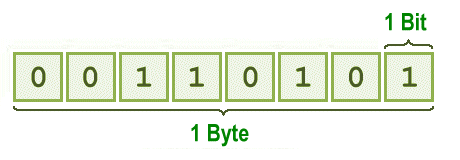

Let's write a function to add up all the positive integers from 1 to $n$:

In [197]:
# add up the numbers
def sum_n(n):
    'add up numbers from 1 to n'
    res = 0
    for i in range(1, n + 1):
        res += i
    return res
    
sum_n(10_000)

50005000

(Of course we already know how to do this in closed form, but humor me.)

For small $n$ this function works great. But what about for large $n$?

In [200]:
%timeit sum_n(100_000_000)

4.67 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Now, let's see what happens when we write the same function in a low-level lanuage.

In [209]:
%%cpp -t

// C implementation

#include <cstdio>

int sum_n(int n) {
    int res = 0;
    for (int i = 0 ; i < n; ++i)
        res += (i + 1);
    return res;
}

int main(int, char**) {
    sum_n(10000000);
}

<TimeitResult : 29.8 ms ± 1.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

- On my machine, the C version takes 30ms, and the Python version takes 490ms;
- So C is about $16\times$ faster.
- Why?

Finally, let's try the same thing using Numpy:

In [215]:
import numpy as np

v = np.arange(1, n + 1)

def sum_n_np(n):    
    return v.sum()

In [216]:
%%timeit
sum_n_np(10_000_000)

1.18 µs ± 12.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


- Numpy is faster than C.

Finally, let's try one more attempt:

In [214]:
v = np.arange(1, 10_000_000 + 1).sum()
%timeit v.sum()

5.71 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


- Much faster than C!
- But much easier to read and write!

# Why is C fast?
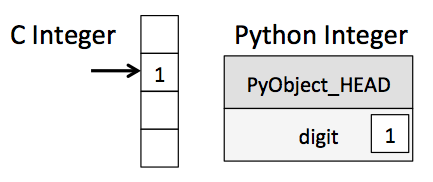

# Why is Python slow?

- Every Python object is simply a cleverly-disguised C structure, which contains not only its value, but other information as well. 
- For example, when we define an integer in Python, such as ``x = 10000``, ``x`` is not just a "raw" integer. It's actually a pointer to a compound C structure, which contains several values.

```C
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};
```

- Benefits: extra information in the Python integer structure is what allows Python to be coded so freely and dynamically. 
- Drawback: Extra overhead in storing an integer in Python as compared to an integer in a compiled language like C.


# Another example: storing a list

In [217]:
L = list(range(10))
L

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [219]:
L2 = [True, "2", 3.0, 4]
[type(item) for item in L2]

sum(L2)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

- This flexibility comes at a cost: each item in the list must contain its own type info, reference count, and other information–that is, each item is a complete Python object. 
- In the special case that all variables are of the same type, much of this information is redundant: it can be much more efficient to store data in a fixed-type array. 

# Why is Numpy almost as fast as C?

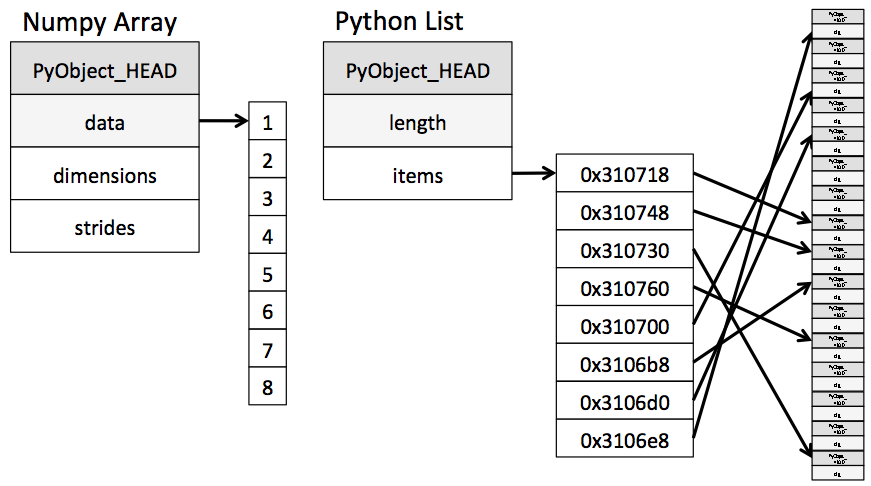














## Down with `for` loops!
- Since almost all data science and statistics problems essentially boil down to manipulating arrays of floating point numbers, we'll exclusively prefer the Numpy-style of working with lists.
- Do not use Python `for` loops except in special cases to be described later!

## Creating Arrays from Python Lists

First, we can use ``np.array`` to create arrays from Python lists:

In [10]:
# integer array:
np.array([1, 4, 2, 5, 3])

array([1, 4, 2, 5, 3])

Remember that unlike Python lists, NumPy is constrained to arrays that all contain the same type.
If types do not match, NumPy will upcast if possible (here, integers are up-cast to floating point):

In [11]:
np.array([3.14, 4, 2, 3])

array([3.14, 4.  , 2.  , 3.  ])

```
array([3.14, 4.  , 2.  , 3.  ])
```









If we want to explicitly set the data type of the resulting array, we can use the dtype keyword:















In [12]:
np.array([1, 2, 3, 4], dtype='float32')

array([1., 2., 3., 4.], dtype=float32)

## Creating Arrays from Scratch¶



Especially for larger arrays, it is more efficient to create arrays from scratch using routines built into NumPy:













In [14]:
np.zeros(10, dtype=int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
np.ones((3, 5), dtype=float)

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [16]:
np.linspace(0, 1, 5)

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [17]:
np.random.random((3, 3))

array([[0.80954592, 0.69225934, 0.327852  ],
       [0.4205031 , 0.30228211, 0.69309193],
       [0.46141987, 0.81724961, 0.00089825]])

In [26]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

```
array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
```











Note that we just created a bunch of two-dimensional arrays. You know these as matrices. For the most part, however, NumPy functions are agnostic to the dimensionality of the array -- they work regardless of the number of dimensions.

## NumPy Standard Data Types¶



| Data type	    | Description |
|---------------|-------------|
| ``bool_``     | Boolean (True or False) stored as a byte |
| ``int_``      | Default integer type (same as C ``long``; normally either ``int64`` or ``int32``)| 
| ``intc``      | Identical to C ``int`` (normally ``int32`` or ``int64``)| 
| ``intp``      | Integer used for indexing (same as C ``ssize_t``; normally either ``int32`` or ``int64``)| 
| ``int8``      | Byte (-128 to 127)| 
| ``int16``     | Integer (-32768 to 32767)|
| ``int32``     | Integer (-2147483648 to 2147483647)|
| ``int64``     | Integer (-9223372036854775808 to 9223372036854775807)| 
| ``uint8``     | Unsigned integer (0 to 255)| 
| ``uint16``    | Unsigned integer (0 to 65535)| 
| ``uint32``    | Unsigned integer (0 to 4294967295)| 
| ``uint64``    | Unsigned integer (0 to 18446744073709551615)| 
| ``float_``    | Shorthand for ``float64``.| 
| ``float16``   | Half precision float: sign bit, 5 bits exponent, 10 bits mantissa| 
| ``float32``   | Single precision float: sign bit, 8 bits exponent, 23 bits mantissa| 
| ``float64``   | Double precision float: sign bit, 11 bits exponent, 52 bits mantissa| 
| ``complex_``  | Shorthand for ``complex128``.| 
| ``complex64`` | Complex number, represented by two 32-bit floats| 
| ``complex128``| Complex number, represented by two 64-bit floats| 

## Aside: representing big integers
- Unlike floating point numbers, it's possible to represent integers exactly in the computer.
- You are only limited by the number of bits you can store.
- In Numpy, that's either 8, 16, 32, or 64 bits.
- However, in Python there is no limit.

In [20]:
100 ** 100  # one google in Python

100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [22]:
np.array([100 ** 100], dtype=int)

OverflowError: Python int too large to convert to C long

- One area where I've found this useful is working with probabilistic models that have big combinatorial coefficients.
- In combination with the `fractions` module, you can do exact arithmetic over the rationals, which sometimes matters for numerical reasons.

## Using Numpy for data
Let's generate a random data matrix `X` and response variable `y`:

In [223]:
n = 10  # observations
p = 3  # predictors
X = np.random.normal(size=(n, p))
y = np.random.normal(size=n)

X

array([[ 0.20741927, -0.818192  , -0.42897125],
       [-1.36719225, -1.68297273, -0.17023196],
       [-1.86973442, -0.25328556, -0.52360728],
       [-0.05603217,  0.25074436, -1.24273618],
       [ 2.12841215, -0.18673398,  0.4787983 ],
       [ 0.54449148, -0.10940624,  0.19319364],
       [-0.33606702,  0.38832209,  0.0385322 ],
       [ 0.22175497,  1.38498247,  0.95992625],
       [-0.90809492, -0.20179897, -0.08992599],
       [-1.26514005, -0.79524108,  0.6880202 ]])

## Basic questions about arrays
- What type of data is it?

In [229]:
X.astype(int)

array([[ 0,  0,  0],
       [-1, -1,  0],
       [-1,  0,  0],
       [ 0,  0, -1],
       [ 2,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  0],
       [ 0,  0,  0],
       [-1,  0,  0]])

What are its dimensions?

In [230]:
X.shape

(10, 3)

How many elements does it have?

In [231]:
X.size

30

How much memory does it take up?

In [232]:
X.nbytes

240

# Aggregations
- Aggregations summarize arrays into lower-dimensional ones. 
- They show up everywhere in statistics and data science.

In [235]:
X.sum(), X.mean(), X.min(), X.max(), X.std()

np.mean(X)

-0.16069222258712526

Some aggregations are called using the `np` library instead of as object methods:

In [127]:
np.median(X)

-0.08302282535439112

In [132]:
np.corrcoef(X, rowvar=False)

array([[ 1.        ,  0.35876949, -0.16693096],
       [ 0.35876949,  1.        , -0.66362509],
       [-0.16693096, -0.66362509,  1.        ]])

# Gotcha: Python vs. NumPy aggregations
- Python also has built in aggregations like `sum()`, `min()`, and `max()`. 
- Don't use these on NumPy arrays! They are slow.

In [252]:
%timeit sum(X)

6.02 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [255]:
%timeit X.min()

1.38 µs ± 6.54 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Multi dimensional aggregates

- One common type of aggregation operation is an aggregate along a row or column.
- Most NumPy aggregation functions have an `axis=` parameter that takes one or more axes and aggregates along them.
- The `.shape` of the resulting array is all the axis that remain.

In [242]:
X.mean()  # aggregate along axis 0 (the n axis)

-0.16069222258712526

In [244]:
X.std(axis=0)  # aggregate along axis 1 (the p axis)

array([1.09982391, 0.77513318, 0.60840655])

# Math with arrays: universal functions (UFuncs)

- Let's perform a common operation with our array: standardize each predictor.
- In order to do that, we need to subtract the mean from each column, and divide by the standard deviation.


In [138]:
X.mean(0)  # column means

array([-0.00783379, -0.33377178,  0.18896449])

In [139]:
X.std(0)  # column std devs

array([0.7554072 , 0.64772483, 0.83404537])

## The wrong way

In [260]:
# using for loops

Xc = X.copy()
mu = X.mean(0)
sigma = X.std(0)

for i in range(n):
    for j in range(p):
        Xc[i, j] = (X[i, j] - mu[j]) / sigma[j]
        
Xc.std(0)

array([1., 1., 1.])

- As we learned earlier in lecture, if we find ourseles writing a Python `for` loop, there is generally a corresponding NumPy operation that has already implemented that.
- This is known as a vectorized operation.
- Vectorized operations in NumPy are implemented via ufuncs, whose main purpose is to quickly execute repeated operations on values in NumPy arrays.


In [261]:
import numpy as np
np.random.seed(0)

def compute_reciprocals(values):
    output = np.empty(len(values))
    for i in range(len(values)):
        output[i] = 1.0 / values[i]
    return output
        
values = np.random.randint(1, 10, size=5)
compute_reciprocals(values)

array([0.16666667, 1.        , 0.25      , 0.25      , 0.125     ])

In [262]:
big_array = np.random.randint(1, 100, size=1_000_000)
%timeit compute_reciprocals(big_array)

1.21 s ± 7.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [263]:
# print(compute_reciprocals(values))
print(1.0 / values)

[0.16666667 1.         0.25       0.25       0.125     ]


In [264]:
%timeit (1.0 / big_array)

1.16 ms ± 5.11 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


- There are ufuncs for every math/trig function you need. 
- (For research-y special functions, see `scipy.special`.)

## The less wrong way

In [269]:
(X[1] - mu) / sigma

array([-0.99759056, -1.91014217, -0.26385605])

In [272]:
# for loop using ufuncs

# using for loops

Xc = X.copy()
mu = X.mean(0)
sigma = X.std(0)

Xc = (X - mu) / sigma

Xc.mean(0)

array([ 3.33066907e-17,  0.00000000e+00, -2.22044605e-17])

# The right way: broadcasting
- Another means of vectorizing operations is to use NumPy's broadcasting functionality.
- Broadcasting is simply a set of rules for applying binary ufuncs (e.g., addition, subtraction, multiplication, etc.) on arrays of different sizes.
- (If you've used R, it has similar broadcasting semantics, with one important exception which is discussed below.)

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:













In [273]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes:















In [277]:
a + np.array([5, 5, 5])

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value 5 into the array [5, 5, 5], and adds the results; the advantage of NumPy's broadcasting is that this duplication of values does not actually take place.















We can similarly extend this to arrays of higher dimensions:

In [278]:
M = np.ones((3, 3)); M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [298]:
v = np.arange(3)
v1 = v
np.array([v] * 3) + M

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

## Rules of Broadcasting
- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is *padded* with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.  (**Different from R**).

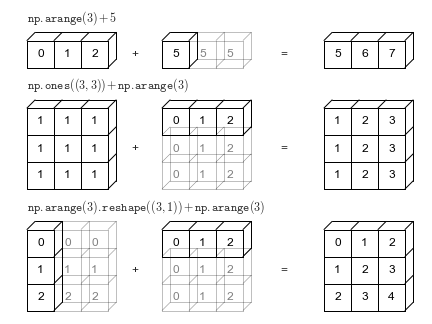

## Example: rank-1 matrix

Consider the outer product $u v^\intercal$ where $u,v$ are vectors of the same dimension.

In [302]:
u = np.arange(3)
v = np.arange(3) + 3

u, v

(array([0, 1, 2]), array([3, 4, 5]))

You might naively hope that expressing $u v^\intercal$ as matrix multiplication would work as God intended.

In [309]:
u.dot(v.T)

14

You would be wrong.

To get this to work, we need to add axes, which is done using either `np.newaxis`, or more idiomatically, `None`:

In [346]:
X[::2, :2]

array([[ 0.20741927, -0.818192  ],
       [-1.86973442, -0.25328556],
       [ 2.12841215, -0.18673398],
       [-0.33606702,  0.38832209],
       [-0.90809492, -0.20179897]])

## Standardizing  the right way

In [347]:
X.mean(0).shape

(3,)

In [164]:
(X - X.mean(0)) / X.std(0)

array([[ 1.64392633,  1.72622737, -0.85967099],
       [-0.08502702, -1.75922421,  0.60582557],
       [ 0.17837787,  1.40185741, -1.90496637],
       [-1.54874149,  0.51071671, -0.33924572],
       [-1.20055905, -0.20099327,  0.69935881],
       [ 1.31144423, -0.20488966,  1.6046082 ],
       [-0.84357476, -1.14891286,  0.36834716],
       [-0.07165865,  0.15120344,  0.33841694],
       [ 0.93729641,  0.04547832, -1.17950082],
       [-0.32148386, -0.52146324,  0.66682723]])

# Reshaping of Arrays
- Often it can be useful to change the shape of an array without modifying the underlying data.
- This is done using the `.reshape()` function.
- The new shape must have the same size as the old shape.

In [356]:
X.reshape(5, 2, 3).mean(axis=1).shape

(5, 3)

- `.reshape()` takes a special argument, `-1`, which will absorb any remaining unspecified dimensions.
- In particular, `.reshape(-1)` flattens the whole array into a vector.

In [172]:
X.reshape(-1)  
X.reshape(10 * 3)

array([ 1.234     ,  0.78434854, -0.52804012, -0.07206382, -1.47326498,
        0.69425051,  0.12691414,  0.57424606, -1.39986389, -1.17776427,
       -0.00296789, -0.09398183, -0.91474475, -0.46396012,  0.77226147,
        0.98284063, -0.46648391,  1.52728053, -0.64507625, -1.07795117,
        0.49618274, -0.06196525, -0.23583356,  0.47121957,  0.70020667,
       -0.30431435, -0.7947927 , -0.25068502, -0.67153647,  0.74512865])

## Uses of reshape
- Often useful for grouping or stratifying data.
- Suppose our $n$ samples are naturally stratified into pairs: $(1, 2), (3, 4), \dots, (9, 10)$.
- We can reshape our $10\times 3$ data matrix into a $5 \times 2 \times 3$ array:

In [173]:
X.reshape(5, 2, 3)[0]  # first two rows of X

array([[ 1.234     ,  0.78434854, -0.52804012],
       [-0.07206382, -1.47326498,  0.69425051]])

Why is this useful? 
- Suppose we wanted to compute the mean predictor within each group.
- This returns a view, so no copying takes place, so it's very fast.

In [174]:
X.reshape(5, 2, 3).mean(axis=1)

array([[ 0.58096809, -0.34445822,  0.08310519],
       [-0.52542507,  0.28563908, -0.74692286],
       [ 0.03404794, -0.46522201,  1.149771  ],
       [-0.35352075, -0.65689237,  0.48370115],
       [ 0.22476082, -0.48792541, -0.02483202]])

## Array Slicing: Accessing Subarrays
- Just as we can use square brackets to access individual array elements, we can also use them to access subarrays with the slice notation, marked by the colon (:) character.
- The NumPy slicing syntax follows that of the standard Python list; to access a slice of an array x, use this:

```
x[start:stop:step]

```
- If any of these are unspecified, they default to the values start=0, stop=size of dimension, step=1.

### One-dimensional subarrays

In [94]:
y[:5]  # first five elements

array([-0.69746464, -0.04752447,  0.71744105,  0.70070289, -0.50653514])

In [95]:
y[5:]  # elements after index 5

array([ 0.56344361, -1.11513262,  0.97993314, -0.11486581,  0.99367934])

In [96]:
y[::2]  # every other element

array([-0.69746464,  0.71744105, -0.50653514, -1.11513262, -0.11486581])

- A potentially confusing case is when the step value is negative.
- In this case, the defaults for start and stop are swapped: start=size of dimension, stop=0.
- This becomes a convenient way to reverse an array:



















In [97]:
y[::-1]  # all elements, reversed

array([ 0.99367934, -0.11486581,  0.97993314, -1.11513262,  0.56344361,
       -0.50653514,  0.70070289,  0.71744105, -0.04752447, -0.69746464])

In [98]:
y[5::-2]  # reversed every other from index 5

array([ 0.56344361,  0.70070289, -0.04752447])

### Multi-dimensional subarrays¶



Multi-dimensional slices work in the same way, with multiple slices separated by commas:













In [99]:
X 

array([[ 3.00000000e+00,  7.84348539e-01, -5.28040116e-01],
       [-7.20638186e-02, -1.47326498e+00,  6.94250505e-01],
       [ 1.26914136e-01,  5.74246060e-01, -1.39986389e+00],
       [-1.17776427e+00, -2.96789351e-03, -9.39818321e-02],
       [-9.14744748e-01, -4.63960118e-01,  7.72261466e-01],
       [ 9.82840627e-01, -4.66483906e-01,  1.52728053e+00],
       [-6.45076246e-01, -1.07795117e+00,  4.96182737e-01],
       [-6.19652495e-02, -2.35833563e-01,  4.71219572e-01],
       [ 7.00206665e-01, -3.04314345e-01, -7.94792699e-01],
       [-2.50685018e-01, -6.71536473e-01,  7.45128651e-01]])

In [101]:
X[:2, :3]  # two rows, three columns

array([[ 3.        ,  0.78434854, -0.52804012],
       [-0.07206382, -1.47326498,  0.69425051]])

In [102]:
X[:3, ::2]  # all rows, every other column

array([[ 3.        , -0.52804012],
       [-0.07206382,  0.69425051],
       [ 0.12691414, -1.39986389]])

One commonly needed routine is accessing of single rows or columns of an array:













In [487]:
n = 10
p = 5

X = np.random.normal(size=(n, p))



X[:, :1].shape  # first predictor

(10, 1)

### Subarrays as no-copy views

- One important–and extremely useful–thing to know about array slices is that they return views rather than copies of the array data.
- This is one area in which NumPy array slicing differs from Python list slicing: in lists, slices will be copies.

In [491]:
X
X_sub = X[:2, :2]

In [492]:
X_sub[:] = 1.234 # if we modify this subarray, the original array is changed too
X

array([[ 1.234     ,  1.234     ,  1.13793193,  2.02600695, -0.02920387],
       [ 1.234     ,  1.234     , -3.21236515, -1.0564065 , -0.10708063],
       [ 0.38101493, -1.2032865 ,  0.73506285, -0.24201158,  0.85567282],
       [ 0.18847571, -0.69971381, -0.85169513,  0.98550726, -0.13635247],
       [ 1.87888848, -1.24752692, -0.2644452 ,  0.28991339, -0.75663696],
       [ 0.19540991,  0.21384274, -0.72142145,  0.43236906,  0.08325719],
       [ 0.51679667,  0.07013717, -0.32429725,  1.97328666, -0.07206247],
       [ 0.34983223,  0.4966692 , -0.24699005, -1.55308928,  0.82499552],
       [ 0.0640416 ,  0.35655709,  0.34966871,  0.71370257,  1.59144689],
       [-0.45779636,  1.70550991, -1.84156244,  0.94332984, -0.38075913]])

# Comparisons, Masks, and Boolean Logic
- Masking comes up when you want to extract, modify, count, or otherwise manipulate values in an array based on some criterion: 
- for example, you might wish to count all values greater than a certain value, or perhaps remove all outliers that are above some threshold.
- In NumPy, Boolean masking is often the most efficient way to accomplish these types of tasks.
- Boolean masking works similar to R.

Comparison operators are ufuncs that return a special type of array called boolean (True/False).















In [497]:
y[y > .01]

array([0.21188038, 0.05964591, 1.19302456])

In [ ]:
These can be used to index (like in R):

In [184]:
y[y > .1]  # all responses that were greater than .1

array([0.71744105, 0.70070289, 0.56344361, 0.97993314, 0.99367934])

If you pass a boolean vector to a multidimensional array, it will index along the leading axis:

In [503]:
(y > .1).sum()

X[:, y > .1]  # data rows for the y > .1 observations

IndexError: boolean index did not match indexed array along dimension 1; dimension is 5 but corresponding boolean dimension is 10

## Placeholders
- What if we wanted to filter on columns instead of rows?
- For example, keep all the predictors that had a stddev of > .8.

In [364]:
X[X.std(0) > .8]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 3

To do this correctly we need to use placeholders, which will allow us to access "deeper" (further to the right) dimensions of the array:

In [365]:
X[:, X.std(0) > .8]

array([[ 0.20741927],
       [-1.36719225],
       [-1.86973442],
       [-0.05603217],
       [ 2.12841215],
       [ 0.54449148],
       [-0.33606702],
       [ 0.22175497],
       [-0.90809492],
       [-1.26514005]])

# Fancy Indexing
- We saw how to access and modify portions of arrays using simple indices (e.g., arr[0]), slices (e.g., arr[:5]), and Boolean masks (e.g., arr[arr > 0]).
- We'll look at another style of array indexing, known as fancy indexing, that is like the simple indexing we've already seen, but we pass arrays of indices in place of single scalars.

Fancy indexing is conceptually simple: it means passing an array of indices to access multiple array elements at once:

In [504]:
rng = np.random.default_rng(42)

x = rng.integers(100, size=10)
x

array([ 8, 77, 65, 43, 43, 85,  8, 69, 20,  9])

In [507]:
 # Suppose we want to access three different elements.

[x[3], x[7], x[2]]

x[np.array([3, 7, 2])]

array([43, 69, 65])

Alternatively, we can pass a single list or array of indices:

In [375]:
ind = [3, 7, 4]
x[ind]

array([43, 69, 43])

When using fancy indexing, the shape of the result reflects the shape of the index arrays rather than the shape of the array being indexed:

In [376]:
ind = np.array([[3, 7],
                [4, 5]])
x[ind]

array([[43, 69],
       [43, 85]])

Fancy indexing also works in multiple dimensions:













In [377]:
X = np.arange(12).reshape((3, 4))
X

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

Like with standard indexing, the first index refers to the row, and the second to the column:













In [510]:
row = np.array([0, 1, 2])
col = np.array([2, 1, 3])
X[row, col]


array([ 1.13793193,  1.234     , -0.24201158])

The pairing of indices in fancy indexing follows all the broadcasting rules that we've already seen:













In [379]:
X[row[:, np.newaxis], col]


array([[ 2,  1,  3],
       [ 6,  5,  7],
       [10,  9, 11]])

Remember: with fancy indexing that the return value reflects the broadcasted shape of the indices, rather than the shape of the array being indexed.















## Example: Bootstrapping

- Bootstrapping is an ideal use case for fancy indexing
- Given two samples $X \in \mathbb{R}^{n_1}$ and $Y \in \mathbb{R}^{n_2}$, we want to assess whether $X$ came from a distribution with a lower (higher, different) median than $Y$.
- Example: measuring height/weight between two groups?
- How to test for significance?

In [520]:
X = rng.normal(5, 1, size=100)
Y = rng.normal(5, 1, size=200)

np.median(X) - np.median(Y) 

0.06951960913662791

Nonparametrically bootstrap:

In [525]:
B = 100_000

rng = np.random.default_rng(1)

n1 = len(X)
n2 = len(Y)

X_inds = rng.choice(n1, size=(B, n1), replace=True)
Y_inds = rng.choice(n2, size=(B, n2), replace=True)

Xb = X[X_inds]  # (B, n1)
Yb = Y[Y_inds]  # (B, n2)

boots = np.median(Xb, axis=1) - np.median(Yb, axis=1)  # (B,)
np.quantile(boots, [0.025, 1.0])

# boots.min(), boots.max()

array([-0.30076157,  0.88907749])

## Combined Indexing

For even more powerful operations, fancy indexing can be combined with the other indexing schemes we've seen:













In [380]:
X[2, [2, 0, 1]] # combine fancy and simple indices

array([10,  8,  9])

In [381]:
X[1:, [2, 0, 1]] # combine fancy indexing with slicing

array([[ 6,  4,  5],
       [10,  8,  9]])

In [382]:
mask = np.array([1, 0, 1, 0], dtype=bool)
X[row[:, np.newaxis], mask] # combine fancy indexing with masking

array([[ 0,  2],
       [ 4,  6],
       [ 8, 10]])

## Example: Selecting Random Points

Suppose we have an  $N \times D$ matrix representing $N$ points in $D$ dimensions, such as the following points drawn from a two-dimensional normal distribution:













In [528]:
mean = [0, 0]
cov = [[1, 2],
       [2, 5]]
X = rand.multivariate_normal(mean, cov, 10000)
X.shape

(10000, 2)

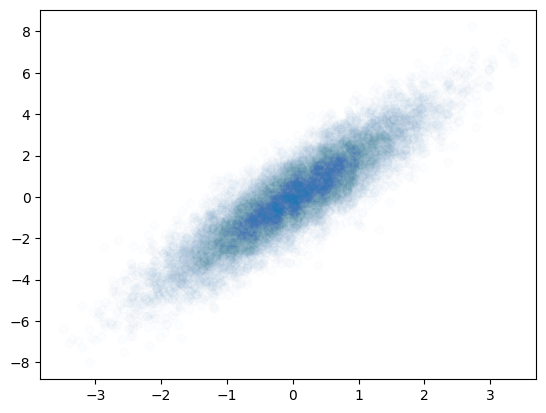

In [530]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], alpha=0.01); 

Let's use fancy indexing to select 20 random points. We'll do this by first choosing 20 random indices with no repeats, and use these indices to select a portion of the original array:

In [541]:
indices = np.random.choice(X.shape[0], 200, replace=False)
indices

array([1718, 7378, 3027, 8057, 1737,  394, 2833,  883, 5796, 4141, 4511,
       6878,  858, 3655, 2276,  817, 5276, 7269, 2671,  462, 5202, 3881,
       7068, 8758, 1643, 7330, 5358, 4948, 5814, 7667, 3699, 3309, 2020,
       2367, 1486, 5672,  166, 3323,  594, 6816, 4589, 5662, 4131, 2804,
       8347, 6317, 6561, 9956, 2091, 3311, 9292,  733, 3499, 4523, 3913,
       3018,  108, 6860, 6153, 1442, 9487, 5236, 1591, 7356, 8407, 8860,
       9166, 9888, 5230, 8495, 2448, 6452,  292, 5390, 1192, 7604, 2880,
       7656, 6928, 4574, 1855, 8984, 4587, 2542, 7492, 7194, 6471, 7542,
       8762,  195,  727, 9428, 3685, 8155, 6550, 4516, 5616, 6492, 6792,
       5449, 3039, 9123, 4227, 5161, 7812, 9331, 2623, 3769,  872,  427,
       2025, 3304, 6212, 7077, 4145, 3140, 8343, 5164, 1535, 7289, 6093,
       8309, 1350, 8745, 7633, 1158, 6345, 8446, 9567, 1918, 1484, 4726,
       3101, 7886, 6343, 2075, 9722, 8756, 1548, 1572, 9730, 6641, 7371,
       7725, 6141, 9571, 8730, 1946, 3144,  876, 33

In [543]:
selection = X[indices]  # fancy indexing here
selection.shape

(200, 2)

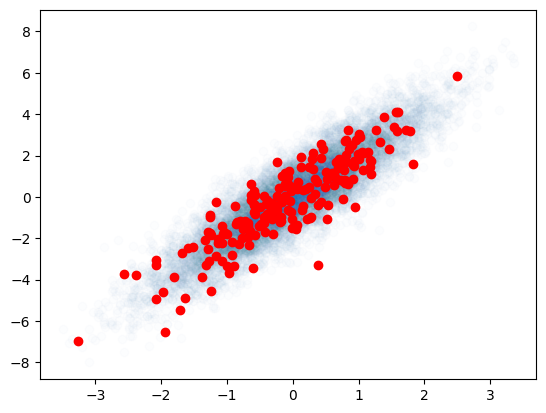

In [544]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.01)
plt.scatter(selection[:, 0], selection[:, 1], color="red")

## Modifying Values with Fancy Indexing
Fancy indexing it can also be used to modify parts of an array:


In [555]:
x = np.arange(10)
i = np.array([[2, 1, 8, 4], [1, 7, 2, 3]])
x[i] = np.arange(2)[:, None]

Notice, though, that repeated indices with these operations can cause some potentially unexpected results:













In [429]:
x = np.zeros(10)
x[[0, 0]] = [4, 6]
x

array([6., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Where did the 4 go? The result of this operation is to first assign x[0] = 4, followed by x[0] = 6.
The result, of course, is that x[0] contains the value 6.





















Here is another example:

In [430]:
i = [2, 3, 3, 4, 4, 4]
x[i] += 1
x

array([6., 0., 1., 1., 1., 0., 0., 0., 0., 0.])

You might expect that x[3] would contain the value 2, and x[4] would contain the value 3, as this is how many times each index is repeated. Why is this not the case?





Conceptually, this is because x[i] += 1 is meant as a shorthand of x[i] = x[i] + 1. x[i] + 1 is evaluated, and then the result is assigned to the indices in x.







With this in mind, it is not the augmentation that happens multiple times, but the assignment, which leads to the rather nonintuitive results.















In [432]:
x = np.zeros(10)
np.add.at(x, i, 1)
x

array([0., 0., 1., 2., 3., 0., 0., 0., 0., 0.])

The at() method does an in-place application of the given operator at the specified indices (here, i) with the specified value (here, 1).
Another method that is similar in spirit is the reduceat() method of ufuncs, which you can read about in the NumPy documentation.

















# Searching and sorting

Up to this point we have been concerned mainly with tools to access and operate on array data with NumPy.
This section covers algorithms related to sorting values in NumPy arrays.

## Searching

- `np.searchsorted(a, v)` returns the index into `a` that `v` would be inserted at.
- (Some special arguments governing ties.)

## Example: weighted sampling

- Suppose I want to sample from a biased 6-sided die.
- $P(X=i) \propto 1 / i,\quad i=1,\dots,6$
- Inverse transform sampling: $X = F_X^{-1}(U)$ has distribution $F_X$.

In [572]:
# inverse transform
i = np.arange(1, 7)
p = 1 / i
p /= p.sum()

F = p.cumsum()

B = 10_000
U = np.random.uniform(size=B)

X = np.searchsorted(F, U) + 1


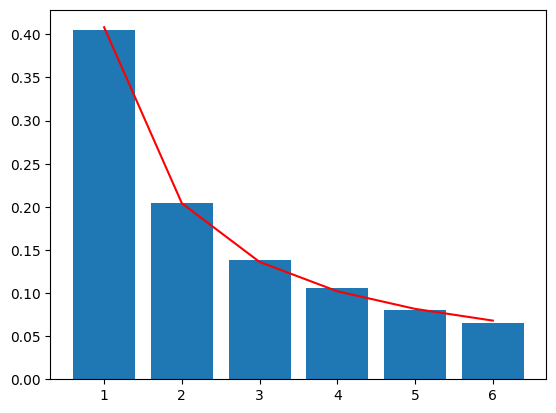

In [579]:
h = np.bincount(X)
h / h.sum(), p
plt.bar(np.arange(1, 7), h[1:] / h.sum())
x = np.linspace(0, 7, 1000)
plt.plot(np.arange(1, 7), p, color="red")

## Example: Histogramming


In [433]:
np.random.seed(42)
x = np.random.randn(100)

# compute a histogram by hand
bins = np.linspace(-5, 5, 20)
counts = np.zeros_like(bins)

# find the appropriate bin for each x
i = np.searchsorted(bins, x)

# add 1 to each of these bins
np.add.at(counts, i, 1)

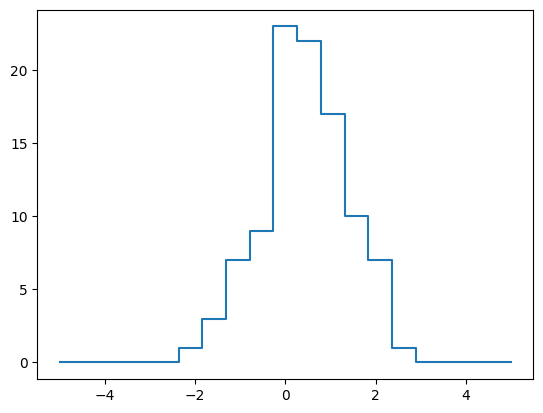

In [438]:
# The counts now reflect the number of points 
# within each bin–in other words, a histogram:
line, = plt.plot(bins, counts, drawstyle="steps-post");

In [439]:
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
17.6 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Custom routine:
11.5 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Our own one-line algorithm is several times faster than the optimized algorithm in NumPy! How can this be?
If you dig into the np.histogram source code (you can do this in IPython by typing np.histogram??), you'll see that it's quite a bit more involved than the simple search-and-count that we've done; this is because NumPy's algorithm is more flexible, and particularly is designed for better performance when the number of data points becomes large...



















In [440]:
x = np.random.randn(1000000)
print("NumPy routine:")
%timeit counts, edges = np.histogram(x, bins)

print("Custom routine:")
%timeit np.add.at(counts, np.searchsorted(bins, x), 1)

NumPy routine:
8.02 ms ± 86.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Custom routine:
87.4 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


What this comparison shows is that algorithmic efficiency is almost never a simple question. An algorithm efficient for large datasets will not always be the best choice for small datasets, and vice versa.

The key to efficiently using Python in data-intensive applications is knowing about general convenience routines like np.histogram and when they're appropriate, but also knowing how to make use of lower-level functionality when you need more pointed behavior.















## Example: Mann-Whitney U
- Test whether $X \in \mathbb{R}^{n_1}$ and $Y \in \mathbb{R}^{n_2}$ have the same distribution.
- Test statistic: $U = \min(U_1,U_2)$ where

    $$U_i = n_1 n_2 + \binom{n_i+1}{2} - R_i$$
    
- $R_i$ is the sum of all the ranks for group $i$ when the full set of observations is ranked.
- $U$ is asymptotically $\mathcal{N}(n_1 n_2/2, \sqrt{n_1 n_2 (n_1 + n_2 + 1)/12})$.

In [607]:
# mann whitney U

X, Y = np.exp(rng.normal(size=(2, 100)))

Y = rng.gamma(1, 1, size=100)
# plt.hist(Y, alpha=.4)

n1 = len(X)
n2 = len(Y)

ni = np.array([n1, n2])
XY = np.concatenate([X, Y])
XY.sort()
Ri = np.searchsorted(XY, np.array([X, Y])).sum(axis=1)
Ui = n1 * n2 + (ni + 1) * ni // 2 - Ri
U = Ui.min()

Z = (U - n1 * n2 / 2) / np.sqrt(n1 * n2 * (n1 + n2 + 1)/12)

Z

-3.689517219560418

## Example: k-Nearest Neighbors

- Given a set of points $X \in \mathbb{n \times p}$, find the the set of $k$ nearest neighbors for each point.
- What's the input?
- What's the output?

We'll start by creating a random set of 10 points on a two-dimensional plane:

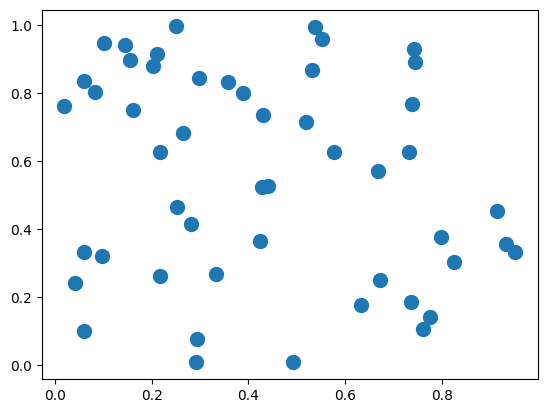

In [608]:
n = 50
X = np.random.rand(n, 2)
plt.scatter(X[:, 0], X[:, 1], s=100);

Compute the distance between each point to each other point:

In [664]:
D = np.linalg.norm(X[:, None] - X[None, :], axis=2)
knn = (D + np.diag([np.inf] * n)).argpartition(2)[:, :2]

plt.scatter(X[:, 0], X[:, 1])
start = X
segments = X[knn]

plt.segments(start)

(50, 2, 2)

For each point, find its $k=2$ nearest neighbors:

In [400]:
k = 2
knn = np.zeros([n, k])
for i in range(n):
    knn[i] = sorted(X[i])[:k]

Now need a function to compute the indices of the two smallest entries in each row:

In [404]:
D[0].argsort()

array([ 0,  9, 20, 43, 36, 37, 31,  6, 11, 30, 16, 46, 23, 17, 33, 29, 27,
       49, 40,  8, 48, 26, 22, 39, 15,  5,  3, 41, 32,  1, 13, 25, 28, 14,
       24,  7, 38,  2, 34, 21, 45, 47, 12, 44, 19, 35,  4, 42, 18, 10])

Notice that the first column is order because each point's closest neighbor is itself.











If we're simply interested in the nearest $k$ neighbors, actually all we need is to partition each row so that the smallest $k + 1$ squared distances come first, with larger distances filling the remaining positions of the array:

In [666]:
nearest_partition = np.argpartition(D, k + 1, axis=1)

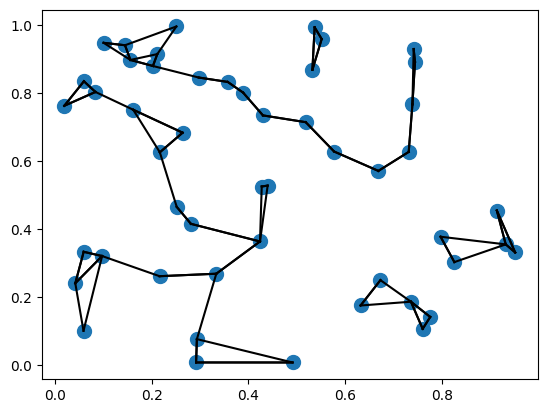

In [667]:
plt.scatter(X[:, 0], X[:, 1], s=100)
K = 2 # draw lines from each point to its two nearest neighbors
for i in range(X.shape[0]):
    for j in nearest_partition[i, :K+1]:
        plt.plot(*zip(X[j], X[i]), color='black')


At first glance, it might seem strange that some of the points have more than two lines coming out of them: this is due to the fact that if point A is one of the two nearest neighbors of point B, this does not necessarily imply that point B is one of the two nearest neighbors of point A.

You might be tempted to do the same type of operation by manually looping through the data and sorting each set of neighbors individually. The beauty of our approach is that it's written in a way that's agnostic to the size of the input data: we could just as easily compute the neighbors among 100 or 1,000,000 points in any number of dimensions, and the code would look the same.






## Searching
If we want to find the point where a value would be inserted into a sorted array, we can use `np.searchsorted()`.

## Fast Sorting in NumPy: np.sort and np.argsort
Although Python has built-in sort and sorted functions to work with lists, NumPy's np.sort function turns out to be much more efficient and useful.

To return a sorted version of the array without modifying the input, you can use np.sort:

















In [421]:
x = np.array([2, 1, 4, 3, 6, 5])
np.sort(x)

array([1, 2, 3, 4, 5, 6])

A related function is argsort, which instead returns the indices of the sorted elements:

















In [422]:
i = np.argsort(x)
i

array([1, 0, 3, 2, 5, 4])

This is a permutation that gives `x` in sort order:

In [427]:
x[i]

array([1, 2, 3, 4, 5, 6])

### Sorting along rows or columns¶















```
rand = np.random.RandomState(42)
X = rand.randint(0, 10, (4, 6))
X

```

































































```
array([[6, 3, 7, 4, 6, 9],
       [2, 6, 7, 4, 3, 7],
       [7, 2, 5, 4, 1, 7],
       [5, 1, 4, 0, 9, 5]])
```















```
np.sort(X, axis=0) # sort each column of X

```



































```
array([[2, 1, 4, 0, 1, 5],
       [5, 2, 5, 4, 3, 7],
       [6, 3, 7, 4, 6, 7],
       [7, 6, 7, 4, 9, 9]])
```













```
np.sort(X, axis=1) # sort each row of X

```



































```
array([[3, 4, 6, 6, 7, 9],
       [2, 3, 4, 6, 7, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 5, 9]])
```









Keep in mind that this treats each row or column as an independent array, and any relationships between the row or column values will be lost!











## Partial Sorts: Partitioning¶



Sometimes we're not interested in sorting the entire array, but simply want to find the k smallest values in the array. np.partition takes an array and a number K; the result is a new array with the smallest K values to the left of the partition, and the remaining values to the right, in arbitrary order:





















```
x = np.array([7, 2, 3, 1, 6, 5, 4])
np.partition(x, 3)

```





































































```
array([2, 1, 3, 4, 6, 5, 7])
```









Note that the first three values in the resulting array are the three smallest in the array, and the remaining array positions contain the remaining values.

Within the two partitions, the elements have arbitrary order.













Similarly to sorting, we can partition along an arbitrary axis of a multidimensional array:













```
np.partition(X, 2, axis=1)

```





































```
array([[3, 4, 6, 7, 6, 9],
       [2, 3, 4, 7, 6, 7],
       [1, 2, 4, 5, 7, 7],
       [0, 1, 4, 5, 9, 5]])
```









The result is an array where the first two slots in each row contain the smallest values from that row, with the remaining values filling the remaining slots.

Finally, just as there is a np.argsort that computes indices of the sort, there is a np.argpartition that computes indices of the partition.













